In [4]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
import matplotlib as mpl
#import scienceplots
from sklearn.metrics import root_mean_squared_error
mpl.rcParams['font.family'] = 'serif'

#### Table of contents 
[1. Tau distribution](#Tau-distribution)  
[2. 2-stream wtih absorption](#2-stream-with-absorption)  
[3. 3d N-stream](#3d-N-stream)  

## Tau distribution

In [2]:
# Generate 1e6 random numbers between 0 and 5 
# make 1000 bins from 0-5  
# probability distribution is the number of values at least > min val of bin
tau_array = [-np.log(1-random.uniform(0, 1)) for i in range(1000000)]

# Make 100 clouds of layers 1-100 
# for each # of layers, count how many photons are transmitted and how many reflected
#optical_depths = np.arange(1, 101, 1)
optical_depths = np.linspace(1, 101, 21)

# set up constants & counts, init empty arrays 
g = 0.85 # from class
prob_back = (1-g)*0.5 # probability backscatter (low prob)
prob_fwd = (1+g)*0.5 # probability forward scatter (high prob)
omega = 0.99  # single-scattering albedo (0.99 = 1% chance of absorption)

In [3]:
hist, bin_edges = np.histogram(tau_array, bins=1000)
bin_width = bin_edges[1] - bin_edges[0]

In [4]:
prob_distribution = hist * bin_width
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
cumulative_prob = np.cumsum(prob_distribution)
ccdf = 1 - cumulative_prob/cumulative_prob[-1] # get cumulative prob dist

Text(0.0, 1.0, 'matching fig 6.4 in book')

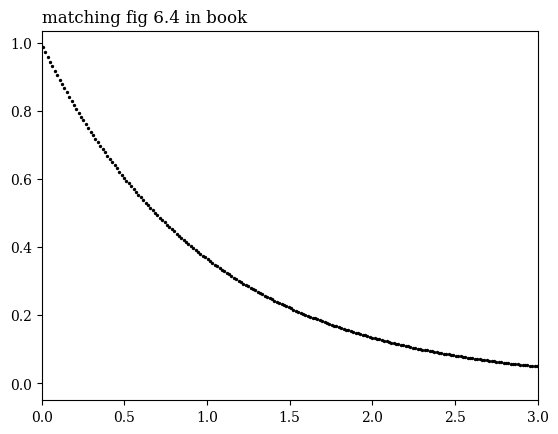

In [5]:
plt.scatter(bin_centers, ccdf, s=2, color="black", label="calculated")
plt.xlim(0, 3)
plt.title("matching fig 6.4 in book", loc="left")

In [6]:
# generate theoretical values for 2 stream no absorption
R_theory=[]
T_theory=[]
for cloud in optical_depths:
    Rt_value = cloud/(cloud+13)
    Tt_value = 1/(1+(cloud*prob_back))
    R_theory.append(Rt_value)
    T_theory.append(Tt_value)

## 2-stream with absorption

In [7]:
# scattering function
def scatter(tau, tau_array, dirscat, optd, numT, numR, numA):
    '''
    If photon is not transmitted (T), reflected (R), or absorbed (A)
    let it keep scattering until it is T, R, or A
    '''
    # if photon has not scattered or reflected, keep doing it
    while 0 < tau < optd:
        # check if photon is absorbed
        if random.uniform(0, 1) > omega:
            numA = numA + 1; dirscat=1; break
        scattau = random.choice(tau_array)
        if prob_fwd>=np.random.uniform():
            tau = tau + dirscat*scattau
            dirscat = dirscat # keep track of the direction of scattering from the original
        else: 
            tau = tau - dirscat*scattau
            dirscat = -dirscat # keep track of the direction of scattering from the original
            
        
        if tau >= optd: numT = numT + 1; dirscat=1; break 
        if tau <= 0: numR = numR + 1; dirscat=1; break 
    
    return numR, numT, numA

In [8]:
def count_RTA(tau_array, num_sims = 1000, optical_depths = optical_depths, g=g, prob_back=prob_back, prob_fwd=prob_fwd):
    '''
    Run montecarlo, keeping track of photons reflected, transmitted, and absorbed
    '''
    
    numR = 0; numT = 0; numA = 0 # set number reflected (R) and transmitted (T) and absorbed (A)
    R_array = [] # array of numR
    T_array = [] # array of numT
    A_array = [] # array of numA
    dirscat = 1 # keep track of the direction of scattering where 1 is forward and -1 is back

    
    for optd in optical_depths: 
        for sim in range(num_sims):
            # get a tau value
            tau = random.choice(tau_array)
            if tau >= optd: numT = numT + 1; continue 
            if tau <= 0: numR = numR + 1; continue 
            # keep scattering until reflected, transmitted, or absorbed
            numR, numT, numA = scatter(tau, tau_array, dirscat, optd, numT, numR, numA)
                
        R_array.append(numR/num_sims)
        T_array.append(numT/num_sims)
        A_array.append(numA/num_sims)
        numR=0
        numT=0
        numA=0

    return R_array, T_array, A_array

In [9]:
num_sims=1e4
R_array_2D, T_array_2D, A_array_2D = count_RTA(tau_array, int(num_sims))

In [10]:
sum_rta = [x + y + z for x, y, z in zip(R_array_2D, T_array_2D, A_array_2D)]
min(sum_rta) # min is somehow not exactly 1, but ignore for now 

0.9999999999999999

In [11]:
max(sum_rta)

1.0

In [12]:
# analytical solution for 2 stream (thank you sarena) 
R_analytical_2D = []
T_analytical_2D = []
A_analytical_2D = []
for tau in optical_depths:
    K = np.sqrt((1-omega)*(1-g*omega))
    R_inf = (np.sqrt(1-omega*g)-np.sqrt(1-omega))/(np.sqrt(1-omega*g)+np.sqrt(1-omega))
    R_g = 0.0
    F0 = num_sims
    A_bar = F0*(R_inf-R_g)*np.exp(-K*tau)/(R_inf*(R_inf-R_g)*np.exp(-K*tau)-(1-R_inf*R_g)*np.exp(K*tau))
    B_bar = -F0*(1-R_inf*R_g)*np.exp(K*tau)/(R_inf*(R_inf-R_g)*np.exp(-K*tau)-(1-R_inf*R_g)*np.exp(K*tau))
    R = (A_bar*np.exp(K*0) + B_bar*R_inf*np.exp(-K*0))/num_sims
    T = (A_bar*R_inf*np.exp(K*tau) + B_bar*np.exp(-K*tau))/num_sims
    A = 1 - R - T

    R_analytical_2D.append(R)
    T_analytical_2D.append(T)
    A_analytical_2D.append(A)

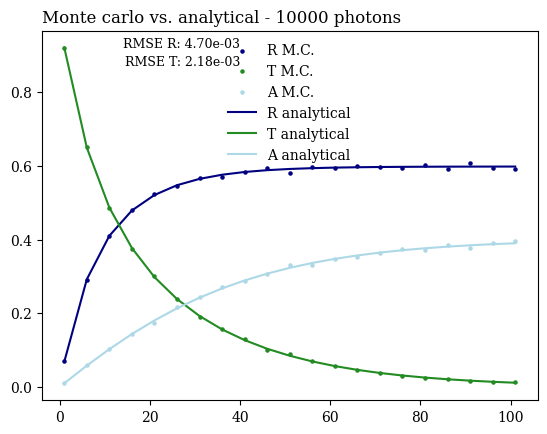

In [13]:
# get % scattered vs. transmitted
R_array, T_array, A_array = count_RTA(tau_array, int(num_sims))

# get rmse from analytical
rmse_R = root_mean_squared_error(R_analytical_2D, R_array_2D)
rmse_T = root_mean_squared_error(T_analytical_2D, T_array_2D)

plt.scatter(optical_depths, R_array_2D, label="R M.C.", s=5, color="navy")
plt.scatter(optical_depths, T_array_2D, label="T M.C.", s=5, color="forestgreen")
plt.scatter(optical_depths, A_array_2D, label="A M.C.", s=5, color="lightblue")
plt.plot(optical_depths, R_analytical_2D, label="R analytical", color="navy")
plt.plot(optical_depths, T_analytical_2D, label="T analytical", color="forestgreen")
plt.plot(optical_depths, A_analytical_2D, label="A analytical", color="lightblue")
plt.title(f"Monte carlo vs. analytical - {int(num_sims)} photons", loc="left")
plt.legend(frameon=False)

plt.text(40, 0.95, f'RMSE R: {"{:.2e}".format(rmse_R)}', fontsize=9, ha='right', va='top')
plt.text(40, 0.9, f'RMSE T: {"{:.2e}".format(rmse_T)}', fontsize=9, ha='right', va='top')
plt.show()

## 3d N-stream

In [14]:
## Andrew lecture notes
# Figure 6.6. in book - Henyey-Greenstein phase function (only depends on g) 
# for convergence maybe calculate RMS difference between HG function and my results
# In andrews the 10^6 was a good number of samples

# TauZ = Tau cos(theta)
# TauX = Tau sin(theta)cos(phi)
# TauY = Tau sin(theta)sin(phi)
# calculate position relative to previous point them absolute position (i.e. did it transmit or reflect?)
# see notes 3D mc 

# first is absorbed?
# if not, scatter, find position
# continue

# compare to figure 6.8 & 6.9 6.10 in the book 
# 6.10 omega=0.999 g=0.85

### Process  
1. We know the direction a photon is going (theta, phi) but not the depth. Select a tau from the distribution at random and then find the global (xyz) position  
2. Use the xyz position to see if it has reflected or transmitted. If neither did it absorb?  
3. If not R or T or A, then scatter randomly via henyey-greenstein function  
4. Now we know the relative direction of scattering (mu) and the original direction (theta and phi from before)  
Find out the global (xyz) direction of scattering based on the local scattering event (mu) and the original direction (theta and phi)  
5. Now we know the global (xyz) direction, but not the depth of scattering. Repeat step 1-2 to generate a random tau and see if the photon was R, T, or A

In [10]:
# stolen from https://github.com/Edenhofer/monte-carlo-radiative-transfer/blob/master/henyey_greenstein.py
def rand_mu(n=1, g=0.85):
    r = np.random.rand(n)
    return ((r * ((1 + g**2 - 2*g)**(-1/2) - (1 + g**2 + 2*g)**(-1/2)) + (1 + g**2 + 2*g)**(-1/2))**-2 - 1 - g**2) / (-2 * g)


def henyey(g, mu):
    return (1 - np.power(g, 2)) / np.power(1 + np.power(g, 2) - 2 * g * mu, 3/2)

In [16]:
omega = 0.99 
g = 0.85 
num_sims = 10000 
optical_depths = np.linspace(1, 101, 21)  # do every 5 to save time
#optical_depths = np.arange(1, 101, 1)  # do every 5 to save time

R_array = []
T_array = []
A_array = []

# iterate through optical depths and save fractions T R and A
for tau in optical_depths:
    print(f"doing tau = {tau}...")
    numR = 0; numT = 0; numA = 0  
    
    # simulate N photos
    for _ in tqdm(range(num_sims)):
        # initially direction going down
        tau_z = 0  # intially at top z = 0
        theta = 0 #np.radians(60) # polar angle - start directly down, but can test np.radians(60) for comparison w/ peters non-absorbing plots
        phi = 0  # azimuthal angle
        #mu = np.cos(theta) 
        
        while True: # keep iterating until a break occurs
            # sample from tau distribution
            scattau = random.choice(tau_array)
            
            # use current direction to calculate position change
            change_tau_z = scattau*np.cos(theta)
            change_tau_x = scattau*np.sin(theta)*np.cos(phi)
            change_tau_y = scattau*np.sin(theta)*np.sin(phi)
            new_tauz = tau_z + change_tau_z  # new z position is former tau + change
            
            # did it reflect or transmit?
            if new_tauz >= tau:  # photon transmitted
                numT += 1
                break
            elif new_tauz <= 0:  # photon reflected
                numR += 1
                break
            else:
                # if not T or R then set tau to new tau, get new scattering direction & repeat
                tau_z = new_tauz
            
            # check if absorbed
            if random.uniform(0, 1) > omega:
                numA += 1
                break
            else:
                # determine how much backward or forward the scattering occurs
                cos_scat = rand_mu(1, g)[0]  # get rand mu
                sin_scat = np.sqrt(1.0 - cos_scat**2)
                
                # get directions from current theta and phi
                sin_theta = np.sin(theta)
                cos_theta = np.cos(theta)
                sin_phi = np.sin(phi)
                cos_phi = np.cos(phi)
                # need to get the scattering angle perpendicular to get total direction so generate a new azimuthal scat angle
                phi_scatter = 2.0*np.pi*np.random.random() # from board in class 4/9
                cos_phi_scat = np.cos(phi_scatter)
                sin_phi_scat = np.sin(phi_scatter)
                
                # use new azimuthal angle and old directional components to get new x,y,&z directions
                # the M matrix in page 8 of lecture 20 converts from local to xyz global frame so we multiply M by scattered direction 
                # convert scattering from spherical to cartesian [sin(theta)cos(phi), sin(theta)sin(phi), cos(theta)] 
                # so we have [sin(theta)cos(phi), sin(theta)sin(phi), cos(theta)]*M (from slide 8)
                # then we get:
                ## z= cos(theta)*cos scat - sin(theta)*sin scat * cos(phi) scat
                ## x= sin(theta)*cos(phi)*cos scat - (cos(theta)*cos(phi)*cos phi scat - sin(phi)*sin phi scat )* sin(scat)
                ## y= sin(theta)*sin(phi)*cos scat - (cos(theta)*sin(phi)*cos phi scat - cos(phi)*sin phi scat )* sin(scat)
                newx = sin_theta*cos_phi*cos_scat + (cos_theta*cos_phi*cos_phi_scat - sin_phi*sin_phi_scat)*sin_scat
                newy = sin_theta*sin_phi*cos_scat + (cos_theta*sin_phi*cos_phi_scat + cos_phi*sin_phi_scat)*sin_scat
                newz = cos_theta*cos_scat - sin_theta*sin_scat*cos_phi_scat
                
                # convert to spherical coordinates for next iteration
                theta = np.arccos(newz)
                phi = np.arctan2(newy, newx)
    
    R_array.append(numR/num_sims)
    T_array.append(numT/num_sims)
    A_array.append(numA/num_sims)

# set to numpy arrays so we can add and check conservation R+T+A=1
R_array = np.array(R_array)
T_array = np.array(T_array)
A_array = np.array(A_array)

# check conservation of energy (make sure fraction adds to 1 for all)
total = R_array + T_array + A_array
print(f"check conservation: 1?-->{np.min(total)} and 1?-->{np.max(total)}")

doing tau = 1.0...


100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 49417.08it/s]


doing tau = 6.0...


100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 7230.05it/s]


doing tau = 11.0...


100%|███████████████████████████████████| 10000/10000 [00:02<00:00, 3693.05it/s]


doing tau = 16.0...


100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 2608.96it/s]


doing tau = 21.0...


100%|███████████████████████████████████| 10000/10000 [00:04<00:00, 2124.20it/s]


doing tau = 26.0...


100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1838.60it/s]


doing tau = 31.0...


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1653.94it/s]


doing tau = 36.0...


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1589.13it/s]


doing tau = 41.0...


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1547.45it/s]


doing tau = 46.0...


100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1466.14it/s]


doing tau = 51.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1426.05it/s]


doing tau = 56.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1421.76it/s]


doing tau = 61.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1410.96it/s]


doing tau = 66.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1386.50it/s]


doing tau = 71.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1395.93it/s]


doing tau = 76.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1354.21it/s]


doing tau = 81.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1403.85it/s]


doing tau = 86.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1330.11it/s]


doing tau = 91.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1395.84it/s]


doing tau = 96.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1384.06it/s]


doing tau = 101.0...


100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1362.42it/s]

check conservation: 1?-->1.0 and 1?-->1.0


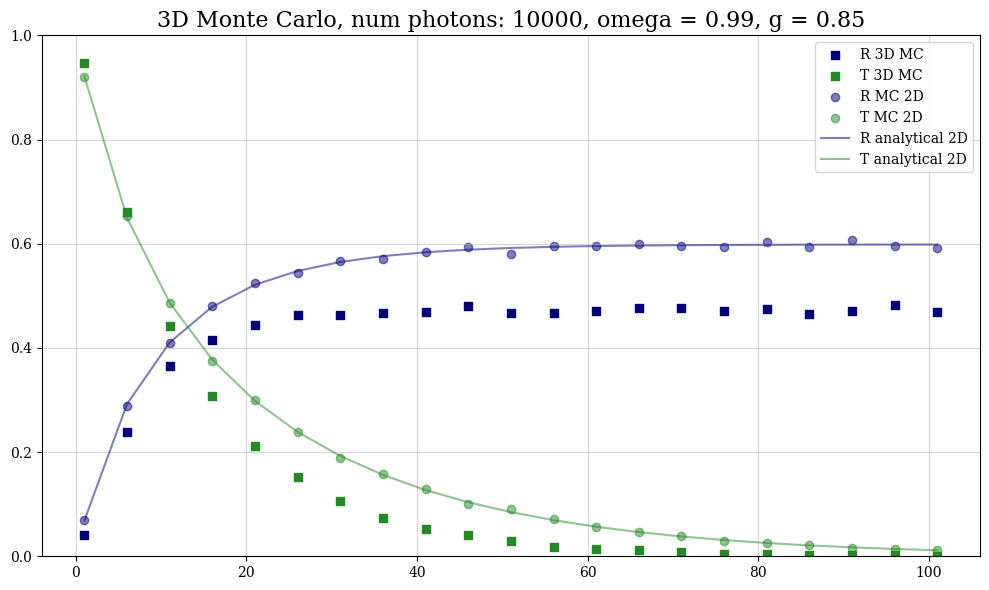

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# 3D 
ax.scatter(optical_depths, R_array, color="navy", marker='s', label='R 3D MC')
ax.scatter(optical_depths, T_array, color="forestgreen", marker='s', label='T 3D MC')
#ax2.plot(optical_depths, A_array, color='lightblue', marker='s', linestyle='-', label='A 3D MC')

# 2D 
ax.scatter(optical_depths, R_array_2D, color='navy', alpha=0.5, label='R MC 2D')
ax.scatter(optical_depths, T_array_2D, color='forestgreen', alpha=0.5, label='T MC 2D')
ax.plot(optical_depths, R_analytical_2D, color='navy', alpha=0.5, linestyle='-', label='R analytical 2D')
ax.plot(optical_depths, T_analytical_2D, color='forestgreen', alpha=0.5, linestyle='-', label='T analytical 2D')


ax.set_ylim(0, 1.0)
ax.set_ylim(0, 1.0)
ax.grid(alpha=0.5)

plt.title(f"3D Monte Carlo, num photons: {num_sims}, omega = {omega}, g = {g}", fontsize=16)

ax.legend()
plt.tight_layout()
plt.show()